In [1]:
DATA_DIR = 'data/train/'


try:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Thesis/code/
  %ls
except:
  colab = False

In [2]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras.layers as layers
from keras.models import Sequential
from preprocessing.keras import preprocess_test_windowed_UL, preprocess_train_windowed_UL
from emp.models.prmc.keras import PRMCModel
from emp.losses.prmc.keras import PRMCLoss
from emp.metrics.maintenance import calculate_PRMC
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.callbacks import LearningRateScheduler
from keras.models import Model

from functools import partial
from scipy.stats import lognorm
import scipy.integrate as integrate

import matplotlib.pyplot as plt

import pickle
from keras.losses import Loss


In [3]:
def predict_test_set(model, test_x):
    """
    Simulate the model on the testset. 

    @test_x: list of numpy arrays representing the observed sensors throughout time
    """
    predicted_RUL_list = []
    for machine in test_x:
        pred_RUL = model(machine)
        predicted_RUL_list.append(pred_RUL)

    return predicted_RUL_list
    
def unravel_labels_testset(preds):
    """Unravel labels into a np.array 

    Args:
        preds (list[np.array]): list of numpy arrays. Each numpy array corresponds to a machine and every value in such array corresponds to 
                                a prediction for a given moment in time for that specific machine

    """

    out = np.zeros((len(preds),max(list(map(lambda x: len(x),preds)))))
    for row, machine in enumerate(preds):
        out[row, 0:len(machine)] = np.ravel(machine)

    return out


In [4]:
files=pd.DataFrame()

for iter, item in enumerate(os.listdir(DATA_DIR)):
    iter +=1
    temp = pd.read_csv(DATA_DIR+item,sep=' ',header=None)
    temp[0]=temp[0].apply(lambda x: f"{iter}-{str(x)}")
    files = pd.concat([files,temp]).reset_index(drop=True)
files.drop(columns=[26,27], inplace=True)
files.columns =  ['unit_ID','cycles','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

window_size = 20
MODEL_NAME = f'LSTM delme'
EPOCHS = 50
batch_size=512
BUFFER_SIZE=40000
acquisition_cost = 50000000
cost_reactive = acquisition_cost/3
cost_predictive = cost_reactive/3


##### SHARED COSTS OR NOT?:
shared = False
##### epochs?
epochs = EPOCHS


# files=files.merge(files.groupby('unit_ID').max('cycles')['cycles'].rename('UL'),left_on='unit_ID',right_index=True)
# files['RUL'] = files['UL']-files['cycles'] #create 'RUL-variable' for every row
# test_ids = random.sample(list(set(files.unit_ID)),round(len(set(files.unit_ID))*0.1))

# test_data = pd.DataFrame()
# train_data = files

# for test_id in test_ids:
    
#     test_data = pd.concat([test_data,train_data[train_data.unit_ID == test_id]])
#     train_data = train_data[train_data.unit_ID != test_id]

#insertion 16/08
train = pd.read_csv('data/gold/train.csv')
validation = pd.read_csv('data/gold/validation.csv')
train_data = train
test_data=validation
#insertion 16/08

basetable_x, basetable_y, train_UL = preprocess_train_windowed_UL(train_data,window_size=window_size)

cost_RUL = acquisition_cost/train_UL #calculate cost of rul

basetable_y=basetable_y.astype(np.float32)
cost_RUL = cost_RUL.astype(np.float32).reshape((cost_RUL.shape[0],))

basetable_x_test, test_y, test_UL = preprocess_test_windowed_UL(test_data,window_size=window_size)


cost_RUL_test = [(acquisition_cost/ul).astype(np.float32) for ul in test_UL] #calculate cost of rul

test_y= [y.astype(np.float32) for y in test_y]

scaler = StandardScaler()


train_x, train_y = basetable_x, basetable_y

train_x=scaler.fit_transform(train_x.reshape(-1,train_x.shape[-1])).reshape(train_x.shape)
test_x=[scaler.transform(machine.reshape(-1,machine.shape[-1])).reshape(machine.shape) for machine in basetable_x_test]

input = keras.Input(shape=(window_size,24))
x = layers.LSTM(128, return_sequences=False, activation = "tanh")(input)
x = layers.Dense(96, activation = "relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1)(x)

model = PRMCModel(inputs=input, outputs = x,name='test')

if not shared:
  lossf = PRMCLoss(cost_reactive,cost_predictive)
  train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y,cost_RUL))
  train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size)

else:
  lossf = PRMCLoss(cost_reactive,cost_predictive,np.mean(cost_RUL))
  train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
  train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size)

model.compile(lossf, optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01))



optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

model.train(train_dataset, lossf, epochs=epochs)

preds_iter = unravel_labels_testset(predict_test_set(model,test_x))
trues_iter = unravel_labels_testset(test_y)
cost_rul = np.array([item[0] for item in cost_RUL_test])
cost_rul_iter = np.array(cost_RUL)


2023-08-16 16:36:10.801759: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-08-16 16:36:10.801783: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-16 16:36:10.801790: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-16 16:36:10.801827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 16:36:10.801843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training with individual costs of rul; dataset dim: (TensorSpec(shape=(None, 20, 24), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))

Start of epoch 0
loss: 2968894208.0 val_loss: 0.0

Start of epoch 1
loss: 2542400256.0 val_loss: 0.0

Start of epoch 2
loss: 2293641984.0 val_loss: 0.0

Start of epoch 3
loss: 2134863360.0 val_loss: 0.0

Start of epoch 4
loss: 2027187712.0 val_loss: 0.0

Start of epoch 5
loss: 1943806592.0 val_loss: 0.0

Start of epoch 6
loss: 1867146368.0 val_loss: 0.0

Start of epoch 7
loss: 1815180416.0 val_loss: 0.0

Start of epoch 8
loss: 1755317120.0 val_loss: 0.0

Start of epoch 9
loss: 1702568320.0 val_loss: 0.0

Start of epoch 10
loss: 1657788032.0 val_loss: 0.0

Start of epoch 11
loss: 1615325696.0 val_loss: 0.0

Start of epoch 12
loss: 1577770240.0 val_loss: 0.0

Start of epoch 13
loss: 1541538432.0 val_loss: 0.0

Start of epoch 14
loss: 1511141248.0 val_loss: 0.0


In [5]:
preds = preds_iter
trues = trues_iter
cost_rul = cost_rul_iter
cost_reactive=50_000_000/3
cost_predictive=cost_reactive/3

title_font = {'size':22}
label_font = {'size':14}


tau = 12

# Analysis

#### One model simulation run:

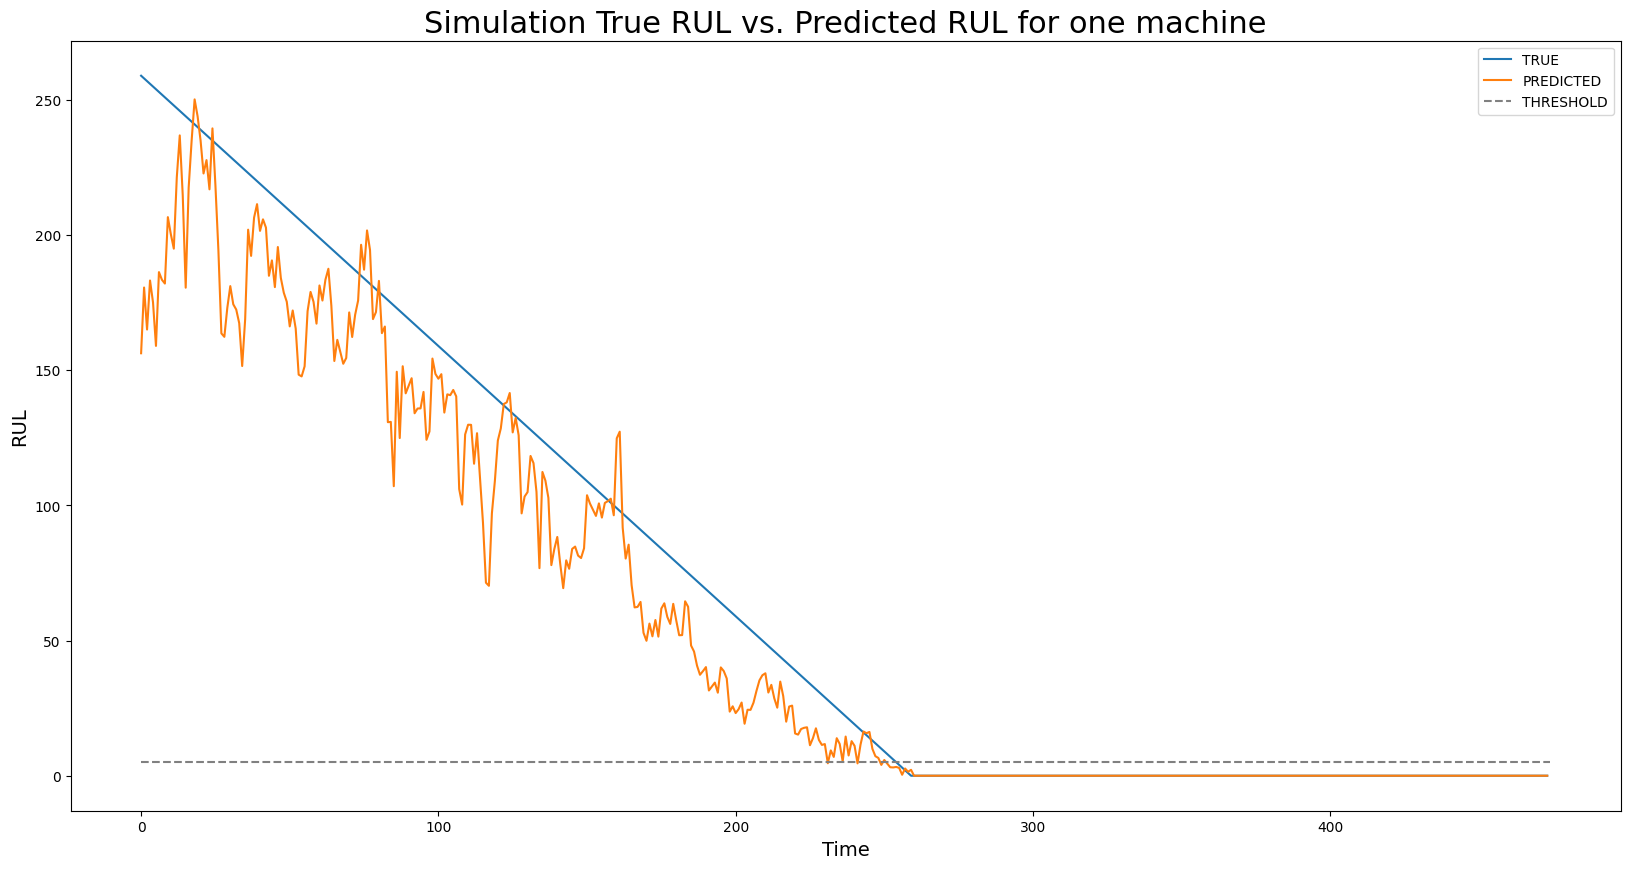

In [6]:
mach = 15

plt.figure(figsize=(20,10))
thresh = np.argmin([np.sum(calculate_PRMC(preds,trues,tau,ti,cost_reactive,cost_predictive,np.mean(cost_rul))) for ti in np.linspace(0.01,150,151)])
plt.plot(np.arange(0,len(trues[mach])),trues[mach],label='TRUE')
plt.plot(np.arange(0,len(preds[mach])),preds[mach],label='PREDICTED')
plt.hlines(thresh,0,len(preds[mach]),linestyles='--',color='gray',label='THRESHOLD')
plt.xlabel('Time',fontdict=label_font)
plt.ylabel('RUL',fontdict=label_font)
plt.title('Simulation True RUL vs. Predicted RUL for one machine',fontdict=title_font)
plt.legend()

### Summed
Shared:

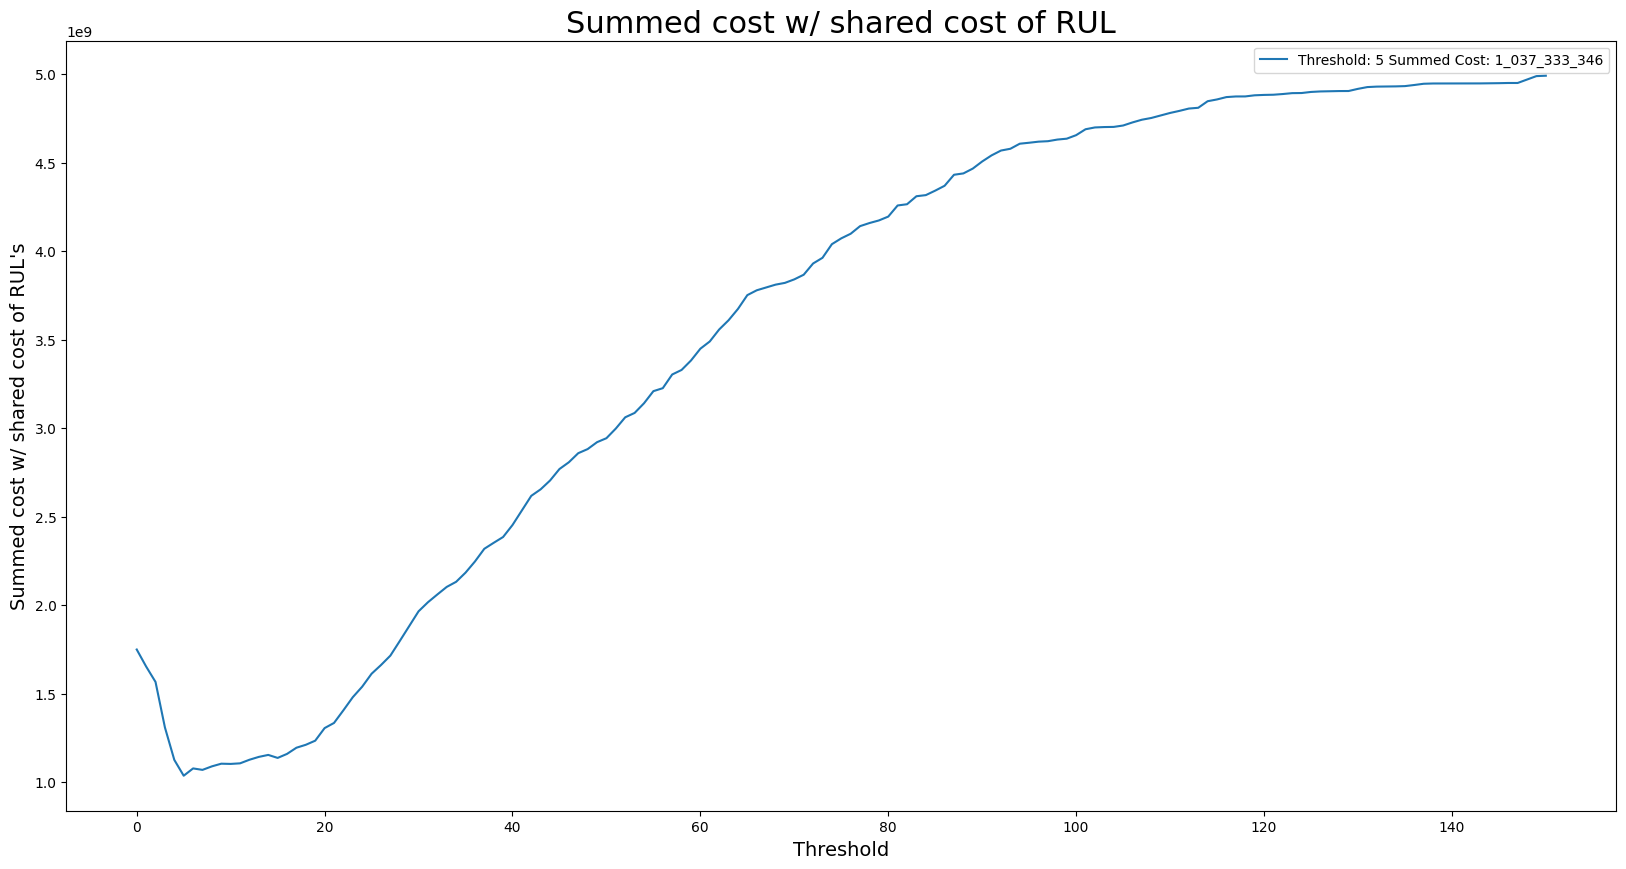

In [7]:
t = np.linspace(0.01,150,151)
plt.figure(figsize=(20,10))

all_costs_to_plot=list()
if type(preds) == list:
    for iter in range(len(preds)):
        costs_to_plot = [np.sum(calculate_PRMC(preds[iter],trues[iter],tau,ti,cost_reactive,cost_predictive,np.mean(cost_rul[iter]))) for ti in t]
        all_costs_to_plot.append(costs_to_plot)
        plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Summed Cost: {round(np.min(costs_to_plot)):_}',linestyle='--')

else:
    costs_to_plot = [np.sum(calculate_PRMC(preds,trues,tau,ti,cost_reactive,cost_predictive,np.mean(cost_rul))) for ti in t]
    plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Summed Cost: {round(np.min(costs_to_plot)):_}')

# plt.plot(t,np.mean(all_costs_to_plot,axis=0),label=f'(AVG) Threshold: {np.argmin(np.mean(all_costs_to_plot,axis=0))} Summed Cost: {round(np.min(np.mean(all_costs_to_plot,axis=0))):_}',linewidth=2.5,linestyle='-')
plt.title('Summed cost w/ shared cost of RUL',fontdict=title_font)
plt.xlabel('Threshold',fontdict=label_font)
plt.ylabel('Summed cost w/ shared cost of RUL\'s',fontdict=label_font)
plt.legend()



Individual:

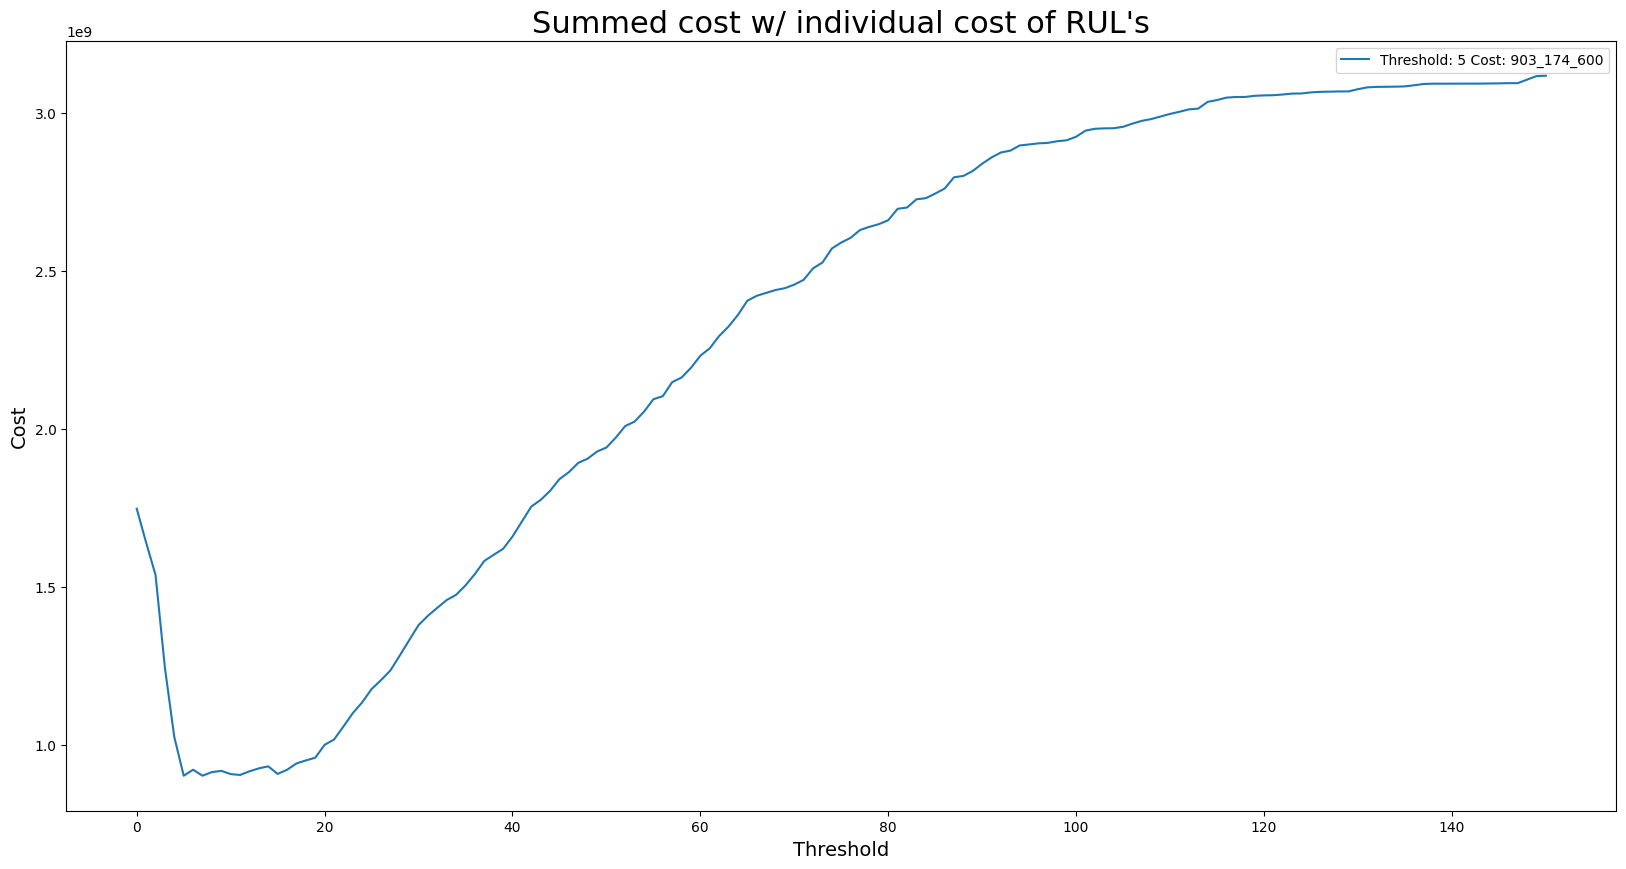

In [8]:
t = np.linspace(0.01,150,151)
plt.figure(figsize=(20,10))

all_costs_to_plot = list()
if type(preds) == list:
    for iter in range(len(preds)):
        costs_to_plot = [np.sum(calculate_PRMC(preds[iter],trues[iter],tau,ti,cost_reactive,cost_predictive,cost_rul[iter])) for ti in t]
        all_costs_to_plot.append(costs_to_plot)
        plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}',linestyle='--')
else:
    costs_to_plot = [np.sum(calculate_PRMC(preds,trues,tau,ti,cost_reactive,cost_predictive,cost_rul)) for ti in t]
    plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}')

# plt.plot(t,np.mean(all_costs_to_plot,axis=0),label=f'(AVG) Threshold: {np.argmin(np.mean(all_costs_to_plot,axis=0))} Summed Cost: {round(np.min(np.mean(all_costs_to_plot,axis=0))):_}',linewidth=2.5,linestyle='-')

plt.title('Summed cost w/ individual cost of RUL\'s',fontdict=title_font)
plt.xlabel('Threshold',fontdict=label_font)
plt.ylabel('Cost',fontdict=label_font)
plt.legend()

### Distribution of costs

Text(0.5, 1.0, 'Distribution of types of costs.')

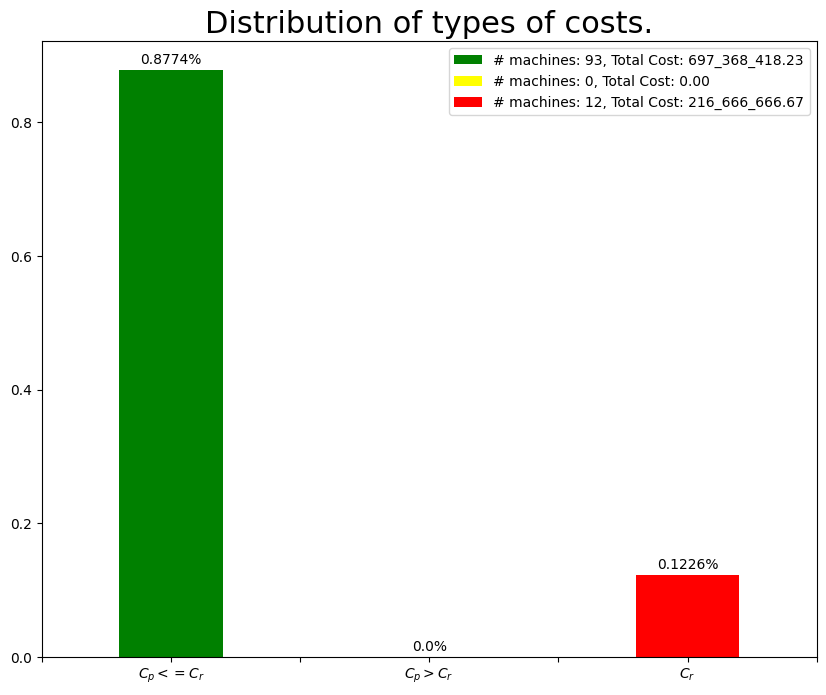

In [9]:
#this only looks at the hypothetical moment of maintenance and failure. The moments still need to be compared
all_PDM=list()
all_failures=list()

threshold = np.argmin(costs_to_plot)


PdM = [(r,np.amin(np.where(preds<=threshold)[1][np.where(preds<=threshold)[0]==r]))for r in set(np.where(preds<=threshold)[0])]
failures = [(r,np.amin(np.where(trues==0)[1][np.where(trues==0)[0]==r])) for r in set(np.where(trues==0)[0])]
all_PDM.append(PdM)
all_failures.append(failures)

cost = np.zeros((len(preds),2))
for idx, (true, pred) in enumerate(zip(failures,PdM)):
    diff_rul = true[1]-pred[1]-tau
    if diff_rul >=0:
        if type(cost_rul) != np.ndarray:
            cost[true[0]][0]=diff_rul * cost_rul[idx] +cost_predictive #take the cost_rul of the corresponding machine
        else:
            cost[true[0]][0]=diff_rul * cost_rul[true[0]] +cost_predictive #take the cost_rul of the corresponding machine
    else:
        cost[true[0]][1]=cost_reactive

failed_machs = sum(cost[:,1])/cost_reactive
predicted_machs = len(cost)-failed_machs
predicted_machs_expensive = len(cost[cost>cost_reactive])
predicted_machs_cheap = predicted_machs-predicted_machs_expensive

failed_machs_ratio=round(failed_machs/cost.shape[0],4)
predicted_machs_expensive_ratio=round(predicted_machs_expensive/cost.shape[0],4)
predicted_machs_cheap_ratio=round(predicted_machs_cheap/cost.shape[0],4)

fig=plt.figure(figsize=(10,8))
fig.patch.set_facecolor('white')
data=[predicted_machs_cheap_ratio,predicted_machs_expensive_ratio,failed_machs_ratio]
labels = [f'# machines: {int(predicted_machs_cheap)}, Total Cost: {np.sum(cost[cost[:,0] <= cost_reactive,0]):_.2f}',
          f'# machines: {int(predicted_machs_expensive)}, Total Cost: {np.sum(cost[cost[:,0] > cost_reactive,0]):_.2f}',
          f'# machines: {int(failed_machs)}, Total Cost: {failed_machs*cost_reactive:_.2f}'
          ]
colors = ['green','yellow','red']
graph = plt.bar([0,2,4],data,color=colors)

for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height+0.01,
             str(p.get_height())+'%',
             ha='center',
             weight='500')


plt.xticks(np.arange(-1,6),labels=['','$C_p <= C_r$','','$C_p > C_r$','','$C_r$',''])

plt.legend(graph,labels)
plt.title(f'Distribution of types of costs.',fontdict=title_font)